In [57]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import io
import base64

In [58]:
def fuzzy_buruk(x, low=30, high=70):
    return np.where(x <= low, 1, np.where(x < high, (high - x)/(high - low), 0))

In [59]:
def fuzzy_baik(x, low=30, high=70):
    return np.where(x <= low, 0, np.where(x < high, (x - low)/(high - low), 1))

def academic_rendah(x, low=25, mid=50):
    return np.where(x <= low, 1, np.where(x < mid, (mid - x)/(mid - low), 0))

In [60]:
def academic_sedang(x, low=25, mid=50, high=75):
    return np.where(
        x < low, 0,
        np.where(x < mid, (x - low)/(mid - low),
        np.where(x <= high, 1,
        np.where(x < 80, (80 - x)/(80 - mid), 0)))
    )

In [61]:
def academic_tinggi(x, mid=50, high=75):
    return np.where(x <= mid, 0, np.where(x < 80, (x - mid)/(high - mid), 1))

In [62]:
def stress_normal(x):
    return np.where(x <= 33, 1, np.where(x < 50, (50 - x)/17, 0))

def stress_sedang(x):
    return np.where(
        x < 33, 0,
        np.where(x < 50, (x - 33)/17,
        np.where(x <= 66, (66 - x)/16, 0))
    )

def stress_tinggi(x):
    return np.where(x <= 66, 0, np.where(x <= 100, (x - 66)/34, 1))

In [63]:
def determine_consequent(rule):
    negative_count = 0
    if rule['Kualitas Tidur'] == 'Buruk':
        negative_count += 1
    if rule['Performa Akademik'] in ['Rendah', 'Sedang']:
        negative_count += 1
    if rule['Hubungan Dosen-Mhs'] == 'Buruk':
        negative_count += 1
    if rule['Support Sosial'] == 'Buruk':
        negative_count += 1
    if rule['Kondisi Kehidupan'] == 'Buruk':
        negative_count += 1

    if negative_count >= 4:
        return 'Tinggi'
    elif negative_count >= 2:
        return 'Sedang'
    else:
        return 'Normal'

In [64]:
def two_category_membership(x, low=30, high=70):
    if x <= low:
        return {'Buruk': 1, 'Baik': 0}
    elif x < high:
        return {'Buruk': (high - x)/(high - low), 'Baik': (x - low)/(high - low)}
    else:
        return {'Buruk': 0, 'Baik': 1}

def academic_performance_membership(x, low=25, mid=50, high=75):
    if x <= low:
        return {'Rendah': 1, 'Sedang': 0, 'Tinggi': 0}
    elif x < mid:
        rendah = (mid - x)/(mid - low)
        sedang = (x - low)/(mid - low)
        return {'Rendah': rendah, 'Sedang': sedang, 'Tinggi': 0}
    elif x <= high:
        return {'Rendah': 0, 'Sedang': 1, 'Tinggi': 0}
    elif x < 80:
        sedang = (80 - x)/(80 - high)
        tinggi = (x - high)/(80 - high)
        return {'Rendah': 0, 'Sedang': sedang, 'Tinggi': tinggi}
    else:
        return {'Rendah': 0, 'Sedang': 0, 'Tinggi': 1}

In [65]:
def compute_stress_level(sleep_quality, academic_performance, hubungan, social_support, living_condition):
    input_dict = {
        'Kualitas Tidur': sleep_quality,
        'Performa Akademik': academic_performance,
        'Hubungan Dosen-Mhs': hubungan,
        'Support Sosial': social_support,
        'Kondisi Kehidupan': living_condition
    }
    
    # Hitung nilai keanggotaan
    memberships = {}
    for factor, value in input_dict.items():
        if factor == 'Performa Akademik':
            memberships[factor] = academic_performance_membership(value)
        else:
            memberships[factor] = two_category_membership(value)
    
    factor_names = list(input_dict.keys())
    category_lists = [list(memberships[factor].keys()) for factor in factor_names]
    
    total_alpha_z = 0
    total_alpha = 0
    for combo in itertools.product(*category_lists):
        mem_values = [memberships[factor_names[i]][combo[i]] for i in range(5)]
        alpha = min(mem_values)
        if alpha > 0:
            rule = {factor_names[i]: combo[i] for i in range(5)}
            consequent = determine_consequent(rule)
            # Z nilai output fuzzy (misal: Normal=25, Sedang=50, Tinggi=75, adjusted dengan alpha)
            if consequent == 'Tinggi':
                z_i = 75 * alpha
            elif consequent == 'Sedang':
                z_i = 50 * alpha
            else:
                z_i = 25 * alpha
            total_alpha_z += alpha * z_i
            total_alpha += alpha
    
    return total_alpha_z / total_alpha if total_alpha > 0 else 50

In [66]:
def plot_membership():
    x = np.linspace(0, 100, 500)

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()

    # Kualitas Tidur
    axs[0].plot(x, fuzzy_buruk(x), label="Buruk")
    axs[0].plot(x, fuzzy_baik(x), label="Baik")
    axs[0].set_title("Kualitas Tidur")
    axs[0].set_ylim(-0.1, 1.1)
    axs[0].legend()

    # Performa Akademik
    axs[1].plot(x, academic_rendah(x), label="Rendah")
    axs[1].plot(x, academic_sedang(x), label="Sedang")
    axs[1].plot(x, academic_tinggi(x), label="Tinggi")
    axs[1].set_title("Performa Akademik")
    axs[1].set_ylim(-0.1, 1.1)
    axs[1].legend()

    # Hubungan Dosen-Mhs
    axs[2].plot(x, fuzzy_buruk(x), label="Buruk")
    axs[2].plot(x, fuzzy_baik(x), label="Baik")
    axs[2].set_title("Hubungan Dosen-Mhs")
    axs[2].set_ylim(-0.1, 1.1)
    axs[2].legend()

    # Support Sosial
    axs[3].plot(x, fuzzy_buruk(x), label="Buruk")
    axs[3].plot(x, fuzzy_baik(x), label="Baik")
    axs[3].set_title("Support Sosial")
    axs[3].set_ylim(-0.1, 1.1)
    axs[3].legend()

    # Kondisi Kehidupan
    axs[4].plot(x, fuzzy_buruk(x), label="Buruk")
    axs[4].plot(x, fuzzy_baik(x), label="Baik")
    axs[4].set_title("Kondisi Kehidupan")
    axs[4].set_ylim(-0.1, 1.1)
    axs[4].legend()

    # Output Tingkat Stres
    axs[5].plot(x, stress_normal(x), label="Normal")
    axs[5].plot(x, stress_sedang(x), label="Sedang")
    axs[5].plot(x, stress_tinggi(x), label="Tinggi")
    axs[5].set_title("Output: Tingkat Stres")
    axs[5].set_ylim(-0.1, 1.1)
    axs[5].legend()

    plt.tight_layout()

    plt.show()




In [67]:
kualitas_tidur = int(input('Kualitas Tidur : '))
performa_akademik = int(input('Performa Akademik : '))
hub_mhs_dosen = int(input('Hubungan Mahasiswa dengan Dosen : '))
support_sosial = int(input('Support Sosial : '))
kondisi_kehidupan = int(input('Kondisi Kehidupan : '))

print('>>> Hasil Deteksi <<<')
stress_level = compute_stress_level(kualitas_tidur, performa_akademik, hub_mhs_dosen, support_sosial, kondisi_kehidupan)
if stress_level < 35:
    tingkat_stress = "Normal"
elif stress_level < 65:
    tingkat_stress = "Sedang"
else:
    tingkat_stress = "Tinggi"

print(f"Level Stress    : {stress_level}")
print(f"Tingkat Stress  : {tingkat_stress}")

>>> Hasil Deteksi <<<
Level Stress    : 25.0
Tingkat Stress  : Normal


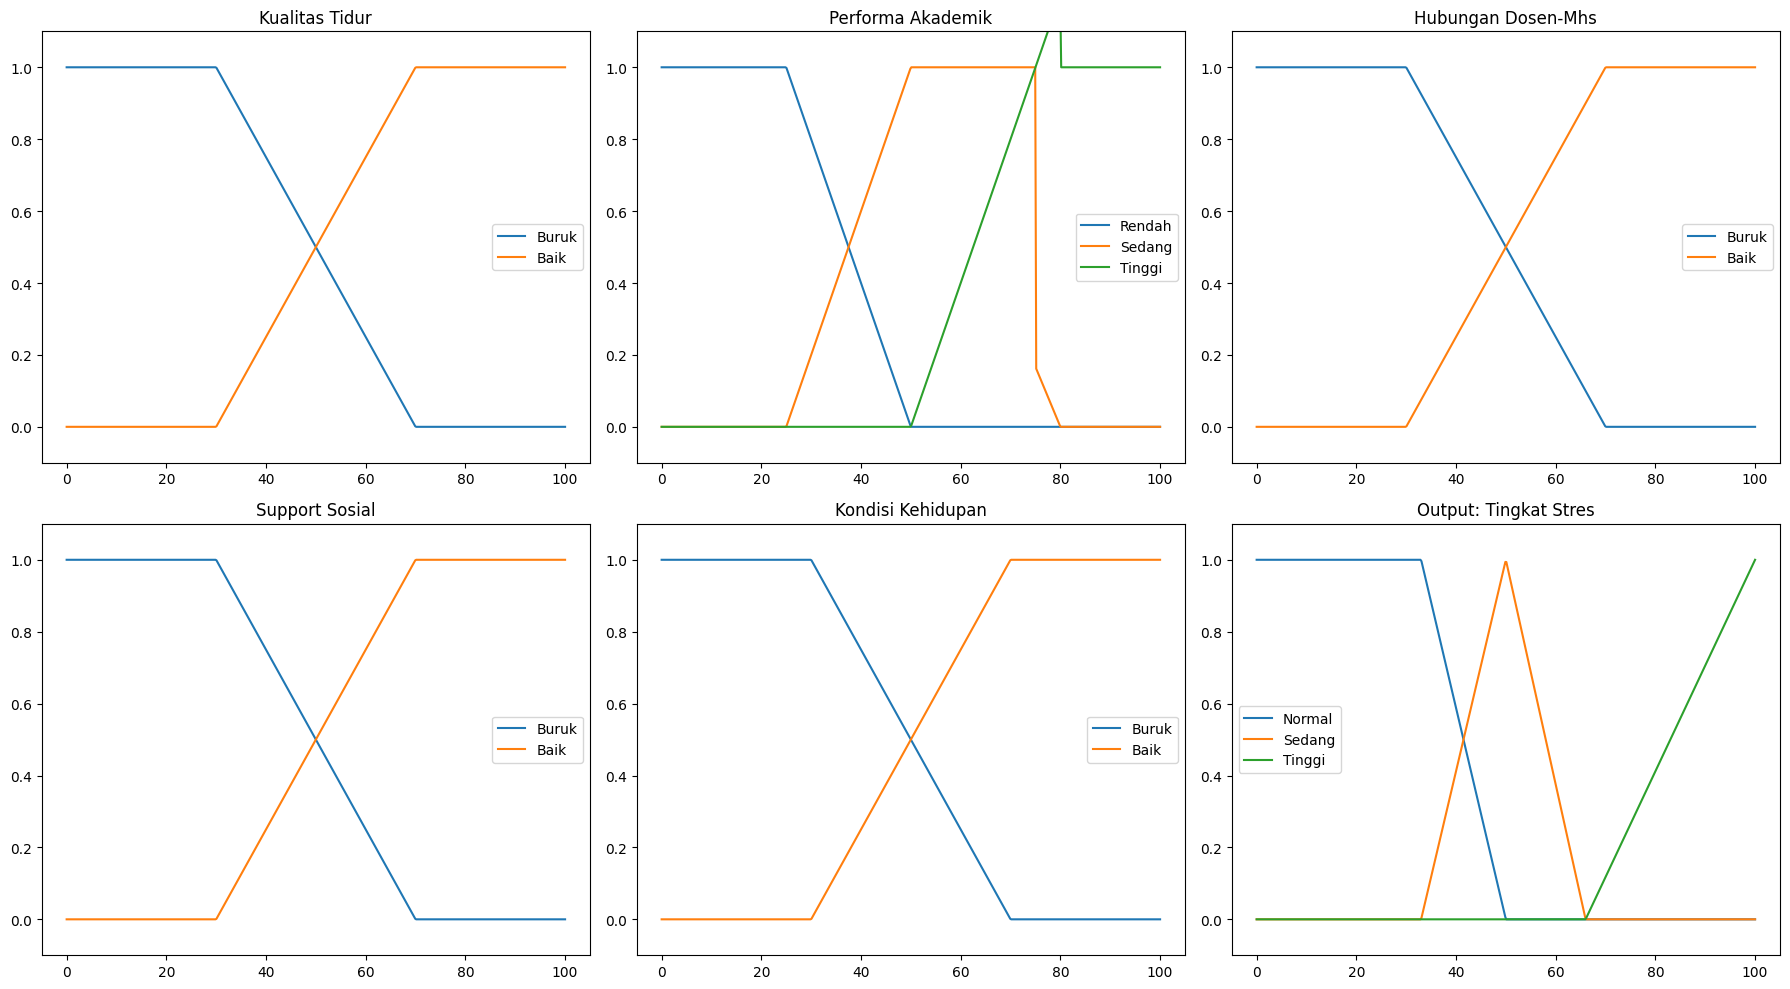

In [68]:
plot_membership()